In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

First, read the spreadsheets into pandas dataframes:

In [2]:
# General data

# Specify the path to the Excel file
file_path = '../data/StatisticalPocketbook/pb2023-section1.xlsx'

# Specify the sheet names
sheet_names = ['general', 'growth', 'empl_rate', 'unempl_rate', 'share_gross_value_added', 'share_empl', 'population', 'trade_import', 'trade_export', 'EU-world']

# Read the specified sheets into a dictionary of DataFrames
general_dfs = pd.read_excel(file_path, sheet_name=sheet_names, header=0, index_col=0)

# Results
for name, df in general_dfs.items():
    print(f"DataFrame for sheet {name}:\n", df.head())

DataFrame for sheet general:
            Area  Population
EU-27  4225.134  446.735291
BE       30.667   11.617623
BG      110.996    6.838937
CZ       78.871   10.516707
DK       42.925    5.873420
DataFrame for sheet growth:
        2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  ...  2012  \
EU-27   0.7  -0.1   0.6   2.6   2.0   4.4   4.0  -1.6 -14.4   7.2  ...  -2.0   
BE      4.2   0.7   1.5   6.3   3.8   6.3   7.7   3.7 -11.0   9.1  ...  -1.8   
BG      2.2   4.6  13.2  12.3   7.3   6.1   9.5   0.6 -18.2   2.0  ...  -0.5   
CZ      6.9   1.8   3.7   9.3   3.1   7.8  10.0  -2.4 -12.9   8.5  ...  -0.9   
DK      2.6   1.6  -0.2  -2.0   3.1   3.6  -3.3  -2.7 -14.1   1.9  ...   0.0   

       2013  2014  2015  2016  2017  2018  2019  2020  2021  
EU-27  -0.6   1.2   2.7   1.8   3.2   1.2  -0.2  -7.3   9.1  
BE      0.0   1.3  -1.2   4.5   2.9   1.1   4.9  -3.8  16.8  
BG      0.1   1.9   2.8   2.5   4.0   0.4   0.6  -6.2  10.1  
CZ      0.1   5.2   4.5   3.1   6.7   3.1  -

Format the relevant data from "General" into 1 dataframe.

In [3]:
# Add population density
general_dfs['general']['PopDensity'] = general_dfs['general']['Population'] / general_dfs['general']['Area']

# Keep only last year entries (most current) for "growth"(industrial production growth); employment and unemployment rate
general_dfs['growth'] = general_dfs['growth'].iloc[:, [-1]]
general_dfs['growth'].columns = ['indust_growth']
general_dfs['empl_rate'] = general_dfs['empl_rate'].iloc[:, [-1]]
general_dfs['empl_rate'].columns = ['empl_rate']

general_dfs['share_gross_value_added'].columns = ['GVA_agriculture', 'GVA_industry', 'GVA_services']
general_dfs['share_empl'].columns = ['emplshare_agriculture', 'emplshare_industry', 'emplshare_services']

general_dfs['trade_import'] = general_dfs['trade_import'].iloc[:, [0]]
general_dfs['trade_import'].columns = ['trade_import_w']
general_dfs['trade_export'] = general_dfs['trade_export'].iloc[:, [0]]
general_dfs['trade_export'].columns = ['trade_export_w']

# Concatenate the DataFrames by row index
chosen_dfs = [general_dfs['general'], general_dfs['growth'], general_dfs['empl_rate'], 
                        general_dfs['share_gross_value_added'], general_dfs['share_empl'], 
                        general_dfs['trade_import'], general_dfs['trade_export']]

# Compile everything into 1 dataframe
general_all = pd.concat(chosen_dfs, axis=1, ignore_index=False)
general_all = general_all.drop("EU-27")

Visualize the distributions:

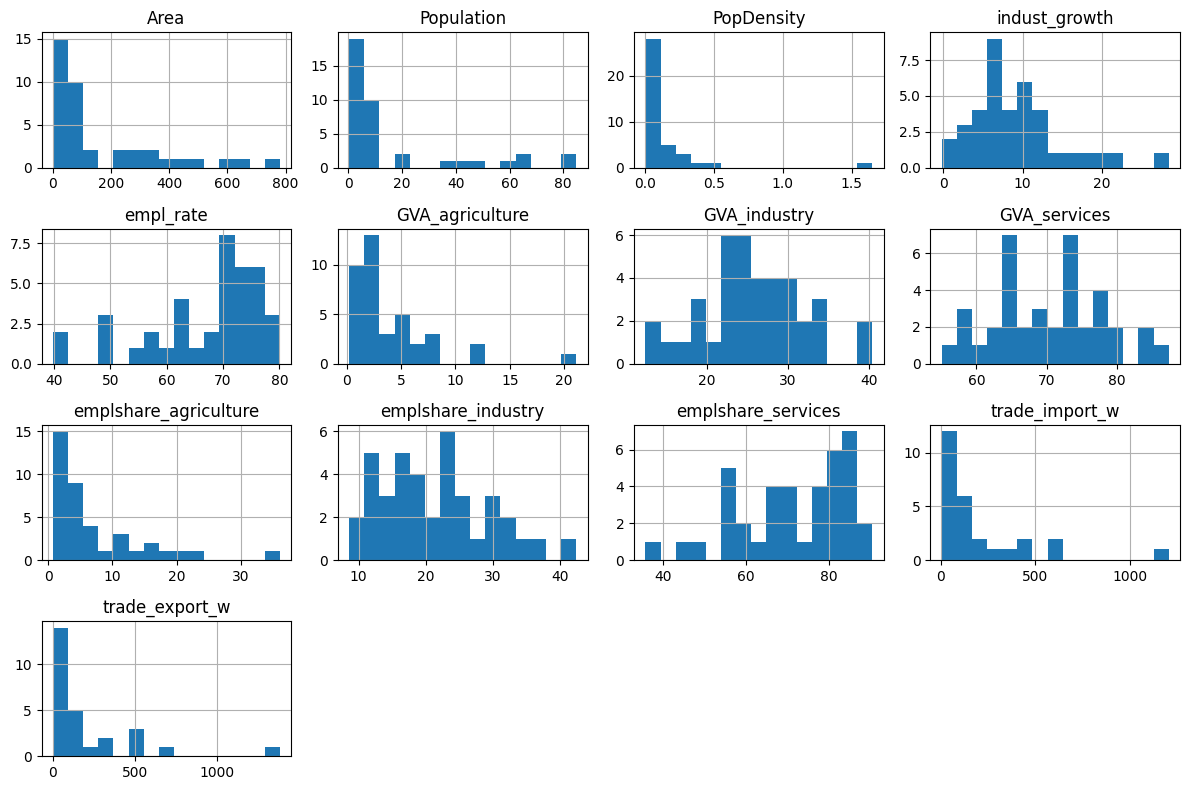

c:\Users\merim\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


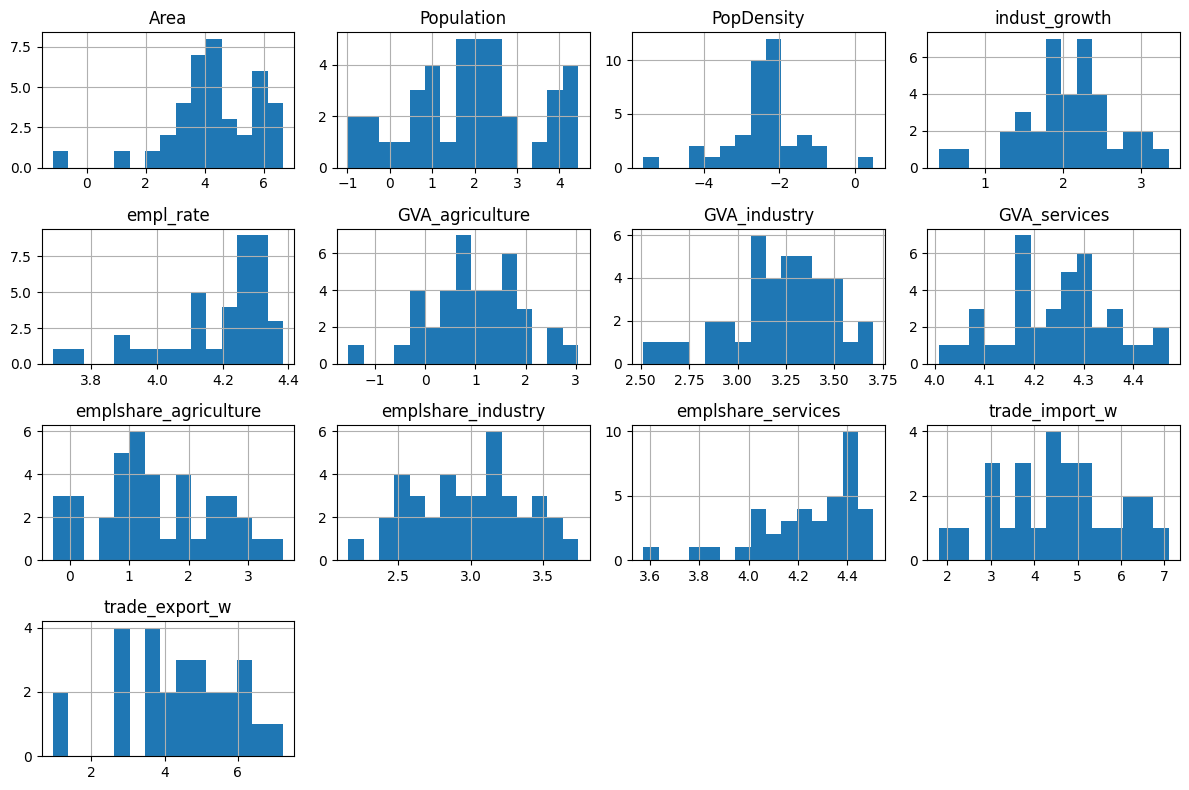

In [4]:
# Plot histograms for each column
general_all.hist(bins=15, figsize=(12, 8))  
plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

# Almost all distributions are skewed, investigating ther log-transformations
general_all_log = general_all.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number) else x)
general_all_log.hist(bins=15, figsize=(12, 8))  
plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

It is definitely beneficial to use log-transformations of all variables (except maybe empl_rate and emplshare_services) when including them in future models, that rely on normally distributed data.

Read the general "Transport" section.

In [5]:
# Transport

# Specify the path to the Excel file
file_path = '../data/StatisticalPocketbook/pb2023_section21.xlsx'

# Specify the sheet names
sheet_names = ['limits', 'empl', 'entrpr', 'house_exp_type', 'price_index', 'tax_fuel', 'tax_otrans']

# Read the specified sheets into a dictionary of DataFrames
transport_dfs = pd.read_excel(file_path, sheet_name=sheet_names, header=0, index_col=0)

# Results
for name, df in transport_dfs.items():
    print(f"DataFrame for sheet {name}:\n", df.head())

DataFrame for sheet limits:
    speed_l_cars_builtup_areas speed_l_cars_outside_builtup_areas  \
BE                         50                     70 / 90  / 120   
BG                         50                                 90   
CZ                         50                           90 / 110   
DK                         50                                 80   
DE                         50                                100   

   speed_l_cars_motorways  blood_alcohol_limit  
BE                    120                  0.5  
BG                120/140                  0.5  
CZ                    130                  0.0  
DK                    130                  0.5  
DE                    130                  0.5  
DataFrame for sheet empl:
            Total  Road freight transport   Road passenger transport   \
EU-27  10243.191                 3283.303                   1792.251   
BE       218.830                   62.292                     19.553   
BG       168.136         

Format the variables and merge

In [6]:
# LIMITS - some entries have multiple values devided by /. We can take the mean from them.
# Define a function for the transformation of entries multiple limits to their mean
def mean_column(column):

    # Split values by '/' and convert to integers
    temp = column.apply(lambda x: [float(val) for val in str(x).split('/')])
    # Calculate mean for rows with multiple values
    temp = temp.apply(lambda x: np.mean(x) if len(x) > 1 else x[0])
    # Convert the column to a numeric data type
    temp = pd.to_numeric(temp, errors='coerce')
    return temp

# Apply the transformation to the specified columns
columns_to_transform = ['speed_l_cars_builtup_areas',
                        'speed_l_cars_outside_builtup_areas',
                        'speed_l_cars_motorways']

for column_name in columns_to_transform:
    transport_dfs['limits'][column_name] = mean_column(transport_dfs['limits'][column_name])

# Number of public transport enterprizes
transport_dfs['entrpr'] = transport_dfs['entrpr'].iloc[:, [2]]
transport_dfs['entrpr'].columns = ['pass_transport_enterpr']

# Transport expenses per head
transport_dfs['house_exp_type'] = transport_dfs['house_exp_type'].iloc[:, [-1]]
transport_dfs['house_exp_type'].columns = ['expenditure_per_head']

# Fuel taxes (as a % of GDP)
transport_dfs['tax_fuel'] = transport_dfs['tax_fuel'].iloc[:, [-3]]
transport_dfs['tax_fuel'].columns = ['tax_fuel']

# other Transport taxes (excl. fuel taxes)
transport_dfs['tax_otrans'] = transport_dfs['tax_otrans'].iloc[:, [-3]]
transport_dfs['tax_otrans'].columns = ['tax_otrans']

# Concatenate the DataFrames by row index
chosen_dfs = [transport_dfs['limits'], transport_dfs['entrpr'], transport_dfs['house_exp_type'], 
                        transport_dfs['tax_fuel'], transport_dfs['tax_otrans']]

# Compile everything into 1 dataframe
transport_all = pd.concat(chosen_dfs, axis=1, ignore_index=False)
transport_all = transport_all.drop("EU-27")

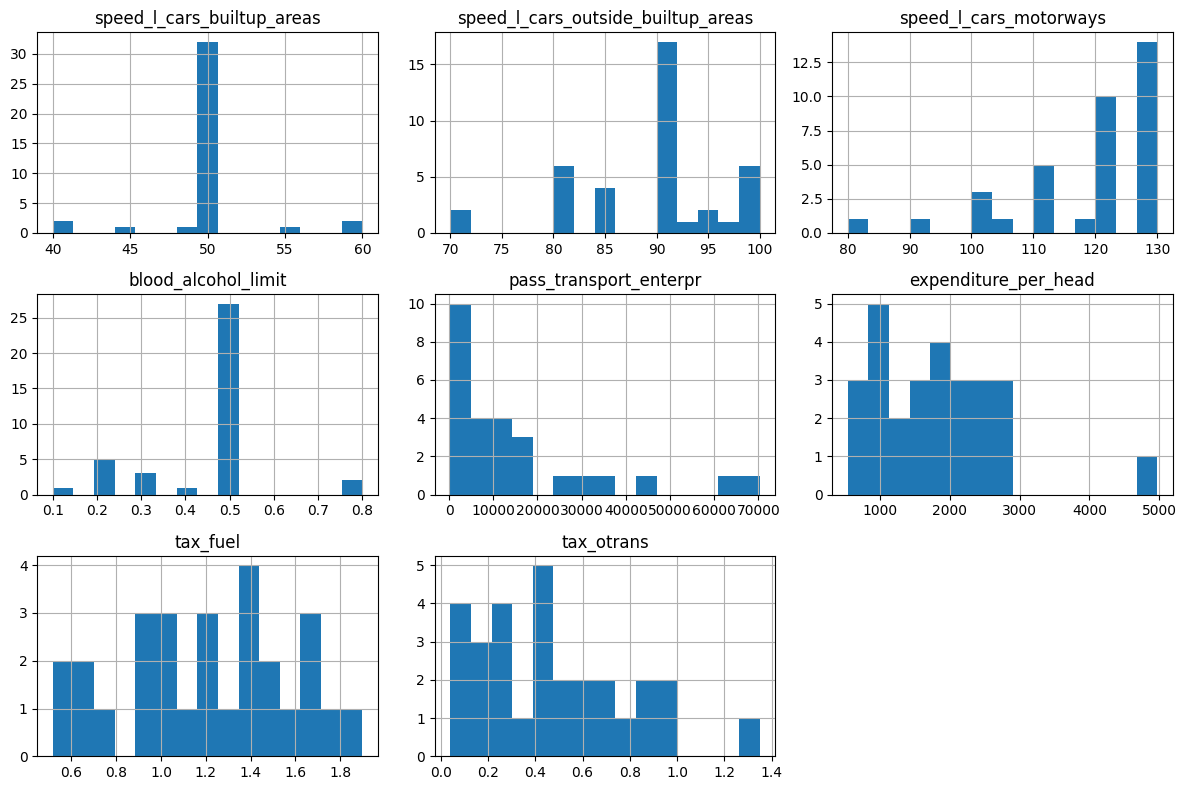

In [7]:
# Plot histograms for each column
transport_all.hist(bins=15, figsize=(12, 8))  
plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

A lot of variables here have a distribution where 1 value is dominant due to EU-wide standards (like speed limits and blood alcohol levels). Tests/models that are not dependent on the normal distribution maybe should be considered.

In [8]:
# Performance of Passenger Transport

# Specify the path to the Excel file
file_path = '../data/StatisticalPocketbook/pb2023_section23.xlsx'

# Specify the sheet names
sheet_names = ['perf_mode_pkm', 'perf_mode_split', 'split_mode_proz', 'split_mode_pkm', 'cars', 'bus_coach', 'tram_and_metro', 'rail_pkm', 'hs_rail']

# Read the specified sheets into a dictionary of DataFrames
passenger_dfs = pd.read_excel(file_path, sheet_name=sheet_names, header=0, index_col=0)

# Remove rows containing only NaN-s
for name, df in passenger_dfs.items():
    df.dropna(how='all', inplace=True)
    print(f"DataFrame for sheet {name}:\n", df.head())

DataFrame for sheet perf_mode_pkm:
         Pass -enger Cars         P2W  Bus & Coach  Rail -way  Tram & Metro  \
1995.0       3283.763535  108.178330   468.028406    312.650     63.801627   
1996.0       3343.400530  109.836143   472.888971    315.471     64.910129   
1997.0       3412.199393  113.861292   475.721780    313.150     65.322641   
1998.0       3507.133868  117.944117   478.187770    311.648     66.047922   
1999.0       3610.557524  121.237876   479.384732    316.507     67.010400   

               Air        Sea        Total  
1995.0  237.232604  22.756607  4496.411111  
1996.0  250.945472  22.551593  4580.003836  
1997.0  267.400912  22.346578  4670.002597  
1998.0  280.428136  22.090310  4783.480124  
1999.0  291.398430  21.834042  4907.930004  
DataFrame for sheet perf_mode_split:
         Passenger Cars       P2W  Bus & Coach   Railway  Tram & Metro  \
1995.0       73.030767  2.405882    10.408933  6.953323      1.418946   
1996.0       72.999950  2.398167    10.32

From the "Performance of Passenger Transport" we have mainly the modal split by different factors expressed in pkm or in %.

First, out of this data we create a data frame modal_split, which includes data in million passenger-kilometers, that will be our main variable.

In [9]:
modal_split = passenger_dfs['split_mode_pkm']
# Drop "Total" column for now
modal_split.drop(modal_split.columns[-1], axis=1, inplace=True)
# Remove countries without data
modal_split = modal_split.dropna(how='all')
# Replace all other NaN-s with 0
modal_split = modal_split.fillna(0)
# Rename columns
modal_split.columns = ['cars', 'bus_coach', 'railways', 'tram_metro']

Creating modal_split_proz (a data frame for modal split in percentage) separately.

In [10]:
modal_split_proz = passenger_dfs['split_mode_proz']
modal_split_proz.set_index('Unnamed: 1', inplace=True)
# Remove countries without data
modal_split_proz = modal_split_proz.dropna(how='all')
# Replace all other NaN-s with 0
modal_split_proz = modal_split_proz.fillna(0)
# Rename columns
modal_split_proz.columns = ['cars', 'bus_coach', 'railways', 'tram_metro']

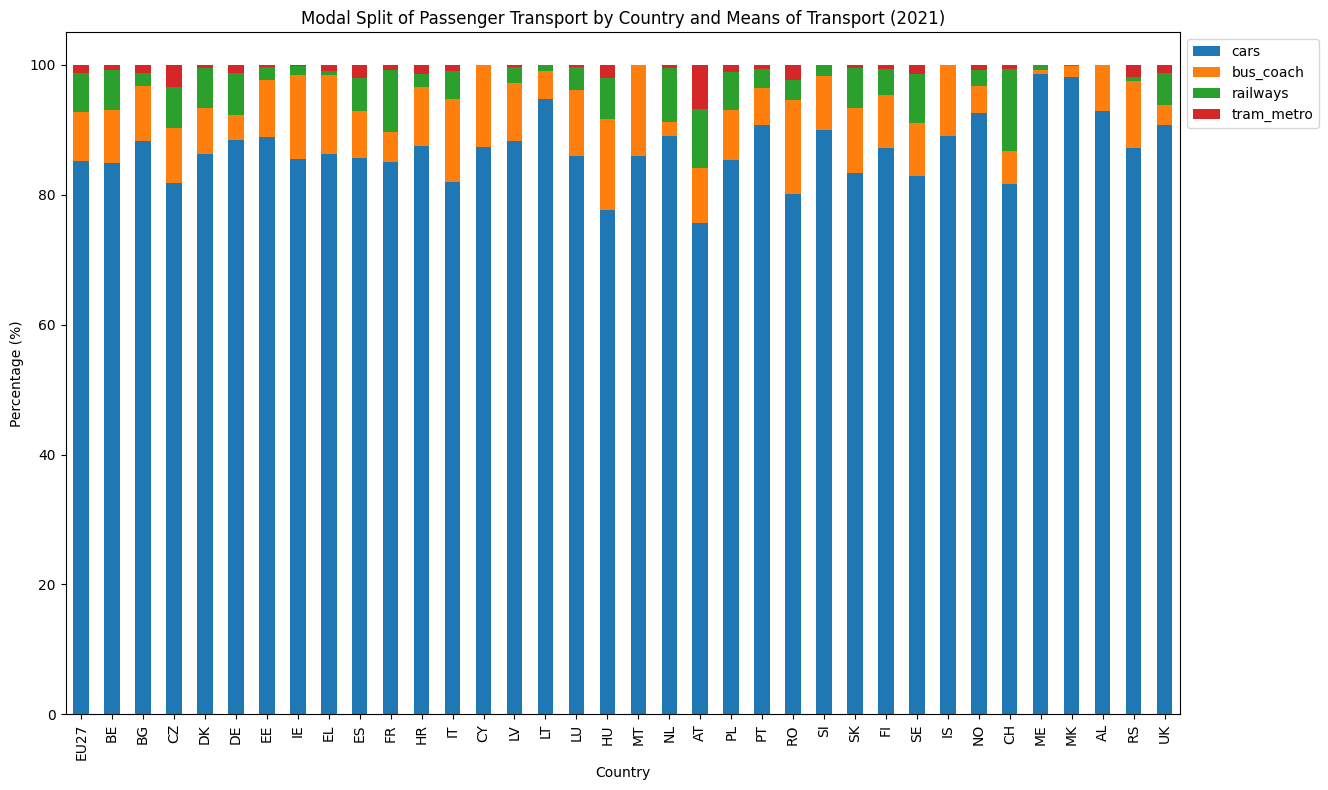

In [11]:
# Plot the modal split as a bar chart
modal_split_proz.plot(kind='bar', stacked=True, figsize=(12, 8))

# Customize the plot
plt.xlabel('Country')
plt.ylabel('Percentage (%)')
plt.title('Modal Split of Passenger Transport by Country and Means of Transport (2021)')
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

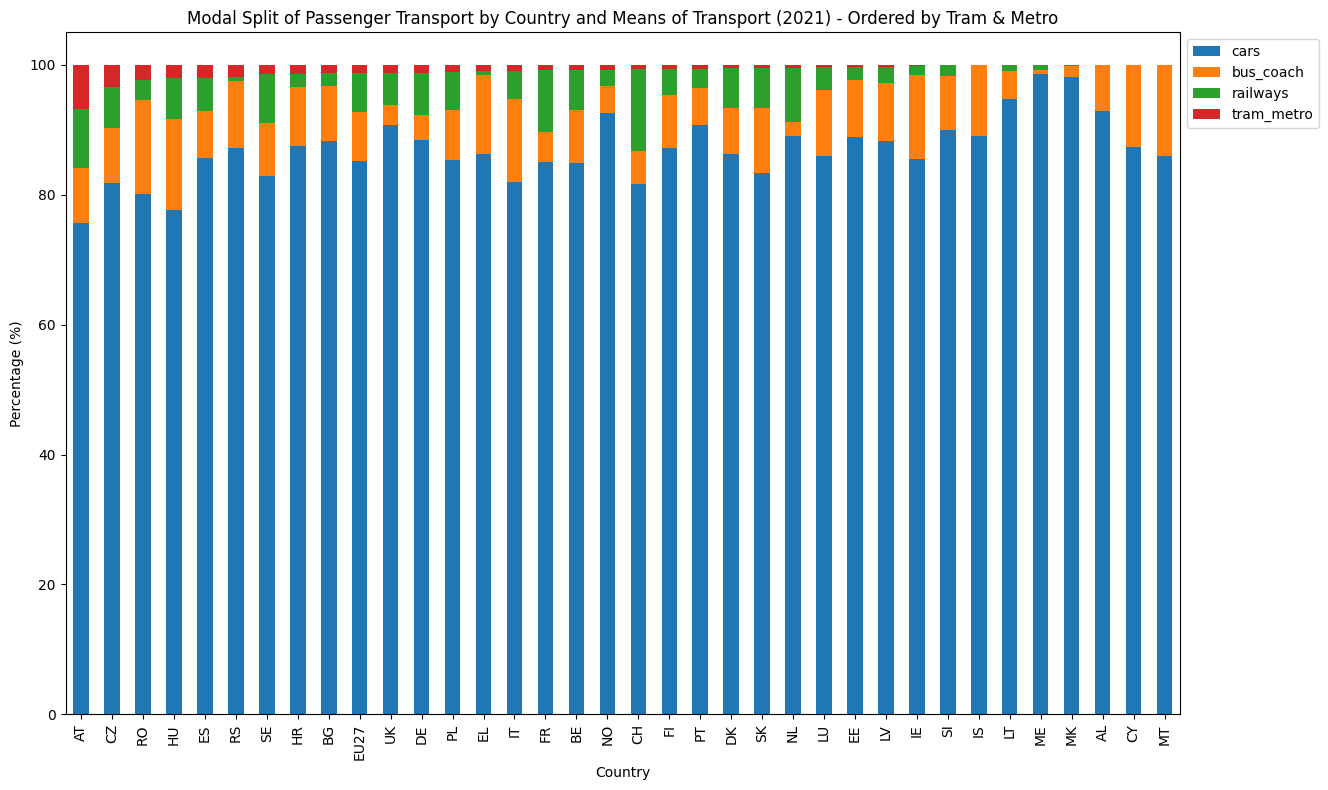

In [12]:
import matplotlib.pyplot as plt

# Sort the DataFrame by the 'tram_metro' column in descending order
modal_split_sorted = modal_split_proz.sort_values(by='tram_metro', ascending=False)

# Plot the modal split as a bar chart
modal_split_sorted.plot(kind='bar', stacked=True, figsize=(12, 8))

# Customize the plot
plt.xlabel('Country')
plt.ylabel('Percentage (%)')
plt.title('Modal Split of Passenger Transport by Country and Means of Transport (2021) - Ordered by Tram & Metro')
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()


In [13]:
# Infrastructure

# Specify the path to the Excel file
file_path = '../data/StatisticalPocketbook/pb2023_section25.xlsx'

# Specify the sheet names
sheet_names = ['motorway', 'length_road', 'rail_length', 'airports', 'ports', 'length_oil']

# Read the specified sheets into a dictionary of DataFrames
infrastructure_dfs = pd.read_excel(file_path, sheet_name=sheet_names, header=4, index_col=1)

# Results
for name, df in infrastructure_dfs.items():
    print(f"DataFrame for sheet {name}:\n", df.head())

DataFrame for sheet motorway:
       Unnamed: 0   1970    1980     1990     1991     1992     1993     1994  \
EU27         NaN    NaN     NaN  38995.0  40000.0  42039.0  42884.0  43537.0   
BE           NaN  488.0  1203.0   1666.0   1650.0   1658.0   1665.0   1666.0   
BG           NaN    NaN     NaN    273.0    273.0    273.0    276.0    276.0   
CZ           NaN    NaN     NaN    357.0    362.0    366.0    390.0    392.0   
DK           NaN  184.0   516.0    611.0    663.0    663.0    706.0    747.0   

         1995     1996  ...     2012       2013       2014       2015  \
EU27  44889.0  45956.0  ...  69290.5  70152.326  70661.272  71585.093   
BE     1666.0   1674.0  ...   1763.0   1763.000   1763.000   1763.000   
BG      277.0    277.0  ...    541.0    605.000    610.000    734.000   
CZ      414.0    423.0  ...    751.0    776.000    776.000    776.000   
DK      796.0    797.0  ...   1195.0   1216.000   1232.000   1237.000   

           2016       2017       2018      2019  

In [14]:
infrastructure_dfs['motorway'] = infrastructure_dfs['motorway'].iloc[:, [-1]]
infrastructure_dfs['motorway'].columns = ['len_motorway']

infrastructure_dfs['length_road']['len_total_road'] = infrastructure_dfs['length_road'].sum(axis=1, skipna=True)
infrastructure_dfs['length_road'] = infrastructure_dfs['length_road'].iloc[:, [-1]]

infrastructure_dfs['rail_length'] = infrastructure_dfs['rail_length'].iloc[:, [-2]]
infrastructure_dfs['rail_length'].columns = ['len_rail']

infrastructure_dfs['length_oil'] = infrastructure_dfs['length_oil'].iloc[:, [-1]]
infrastructure_dfs['length_oil'].columns = ['len_oil']

# Coose dataframes to compile
chosen_dfs = [infrastructure_dfs['motorway'], infrastructure_dfs['length_road'], infrastructure_dfs['rail_length'], 
                        infrastructure_dfs['length_oil']]

# Compile everything into 1 dataframe
infrastructure_all = pd.concat(chosen_dfs, axis=1, ignore_index=False)
infrastructure_all = infrastructure_all.drop("EU27")

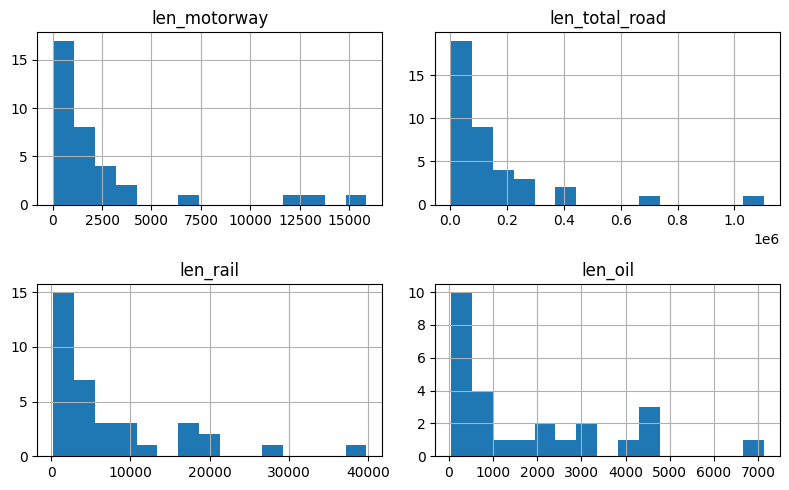

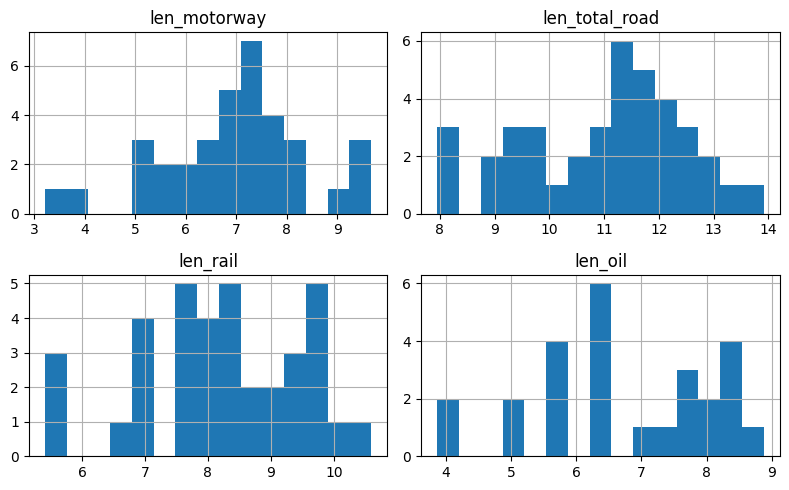

In [15]:
# Plot histograms for each column
infrastructure_all.hist(bins=15, figsize=(8, 5))  
plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

# Investigating log-transformations
infrastructure_all_log = infrastructure_all.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number) else x)
infrastructure_all_log.hist(bins=15, figsize=(8, 5))  
plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

In [16]:
# Means of Transport

# Specify the path to the Excel file
file_path = '../data/StatisticalPocketbook/pb2023_section26.xlsx'

# Specify the sheet names
sheet_names = ['stock_cars', 'stock_busses']

# Read the specified sheets into a dictionary of DataFrames
means_transp_dfs = pd.read_excel(file_path, sheet_name=sheet_names, header=4, index_col=1)

# Remove rows containing only NaN-s
for name, df in means_transp_dfs.items():
    df.dropna(how='all', inplace=True)
    print(f"DataFrame for sheet {name}:\n", df.head())

DataFrame for sheet stock_cars:
        Unnamed: 0      1970      1980       1990        1991        1992  \
EU-27         NaN       NaN       NaN  142905.84  147715.546  151935.890   
BE            NaN  2059.616  3158.737    3864.00    3970.000    4021.000   
BG            NaN       160       820    1317.40    1359.000    1411.300   
CZ            NaN       685      1780    2410.00    2480.000    2580.000   
DK            NaN  1076.875      1390    1590.00    1594.000    1604.053   

             1993        1994        1995        1996  ...        2012  \
EU-27  154504.256  157225.754  160510.827  163940.296  ...  216028.246   
BE       4110.000    4210.000    4273.000    4339.000  ...    5444.000   
BG       1505.451    1587.873    1647.571    1707.023  ...    2807.000   
CZ       2833.143    2923.916    3043.316    3192.532  ...    4706.000   
DK       1617.734    1611.191    1679.007    1738.854  ...    2237.122   

             2013        2014        2015        2016        2017

In [17]:
# Number of registered cars
means_transp_dfs['stock_cars'] = means_transp_dfs['stock_cars'].iloc[:, [-1]]
means_transp_dfs['stock_cars'].columns = ['stock_cars']

# Number of registered busses
means_transp_dfs['stock_busses'] = means_transp_dfs['stock_busses'].iloc[:, [-1]]
means_transp_dfs['stock_busses'].columns = ['stock_busses']

# Compile to 1 dataframe:
chosen_dfs = [means_transp_dfs['stock_cars'], means_transp_dfs['stock_busses']]
means_transp_all = pd.concat(chosen_dfs, axis=1, ignore_index=False)
means_transp_all = means_transp_all.drop("EU-27")


,stock_cars,stock_busses
BE,5927.912000,16.628
BG,2830.464000,17.731
CZ,6088.730000,20.555
DK,2787.553000,11.923
DE,48540.878000,80.225
EE,825.936000,5.374
IE,2250.257000,11.090
EL,5604.192000,26.584
ES,24913.132000,64.300
FR,38738.589603,92.297


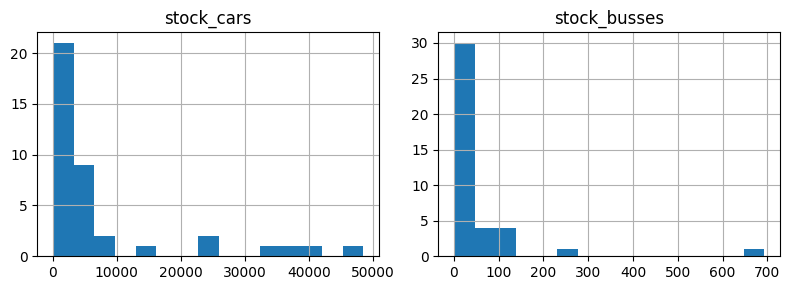

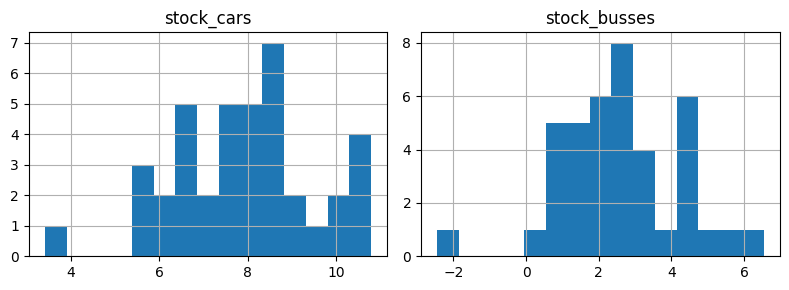

In [18]:
# Plot histograms for each column
means_transp_all.hist(bins=15, figsize=(8, 3))  
plt.tight_layout()  
plt.show()

# Look at log-distribution
np.log(means_transp_all).hist(bins=15, figsize=(8, 3))  
plt.tight_layout()  
plt.show()

In [62]:
# Save all dfs into files
general_all.to_csv('general_all.csv')
transport_all.to_csv('transport_all.csv')
infrastructure_all.to_csv('generainfrastructure_alll_all.csv')
means_transp_all.to_csv('means_transp_all.csv')

# Modal split
modal_split.to_csv('modal_split.csv')
modal_split_proz.to_csv('modal_split_proz.csv')